In [1]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "pleaseletmein"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
run_query("""
RETURN gds.version() 
"""
)

,gds.version()
0,2.2.6


In [4]:
run_query("""
CREATE CONSTRAINT IF NOT EXISTS FOR (s:Stream) REQUIRE s.id IS UNIQUE;
"""
)

""


In [5]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3JjgKgZ" AS row
MERGE (s:Stream {id: row.id})
SET s.language = row.language
"""
)

""


In [6]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3S9Uyd8" AS row
CALL{
    WITH row
    MATCH (s:Stream {id:row.source})
    MATCH (t:Stream {id:row.target})
    MERGE (s)-[r:SHARED_AUDIENCE]->(t)
    SET r.weight = toInteger(row.weight)
} IN TRANSACTIONS
""")

""


In [7]:
run_query("""
CALL gds.graph.project("twitch", "Stream", 
  {SHARED_AUDIENCE: {orientation: "UNDIRECTED", properties:["weight"]}})
"""
)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}",{'SHARED_AUDIENCE': {'orientation': 'UNDIRECTE...,twitch,3721,262854,76


In [8]:
run_query("""
CALL gds.beta.node2vec.write('twitch', 
  {embeddingDimension:8, relationshipWeightProperty:'weight',
   inOutFactor:0.5, returnFactor:1, writeProperty:'node2vec'})
"""
)

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,0,11106,70,"{'negativeSamplingExponent': 0.75, 'initialLea...",[22235480.10901892]


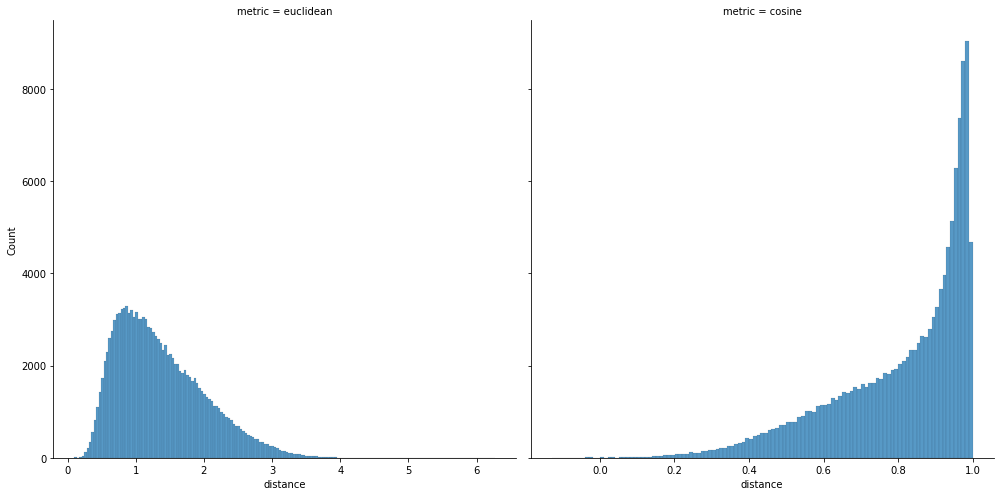

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16, 9]
import seaborn as sns

df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.euclideanDistance(
   c1.node2vec, c2.node2vec) AS distance, 'euclidean' as metric
UNION
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.cosine(
   c1.node2vec, c2.node2vec) AS distance, 'cosine' as metric
"""
)

sns.displot(
    data=df,
    x="distance",
    col="metric",
    common_bins=False,
    facet_kws=dict(sharex=False),
    height=7,
)

<AxesSubplot:xlabel='cosineSimilarity', ylabel='avgDegree'>

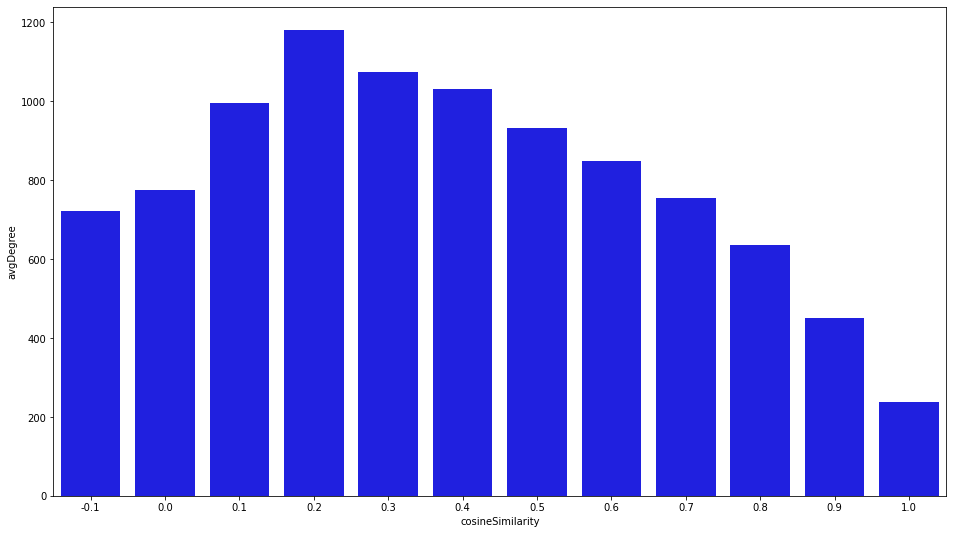

In [10]:
df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
WITH c1, c2, gds.similarity.cosine(c1.node2vec, c2.node2vec) AS cosineSimilarity,
     count{ (c1)-[:SHARED_AUDIENCE]-() } AS degree1,
     count{ (c2)-[:SHARED_AUDIENCE]-() } AS degree2
RETURN round(cosineSimilarity,1) AS cosineSimilarity, avg(degree1 + degree2) AS avgDegree
ORDER BY cosineSimilarity
"""
)

sns.barplot(data=df, x="cosineSimilarity", y="avgDegree", color="blue")

<AxesSubplot:xlabel='cosineSimilarity', ylabel='avgWeight'>

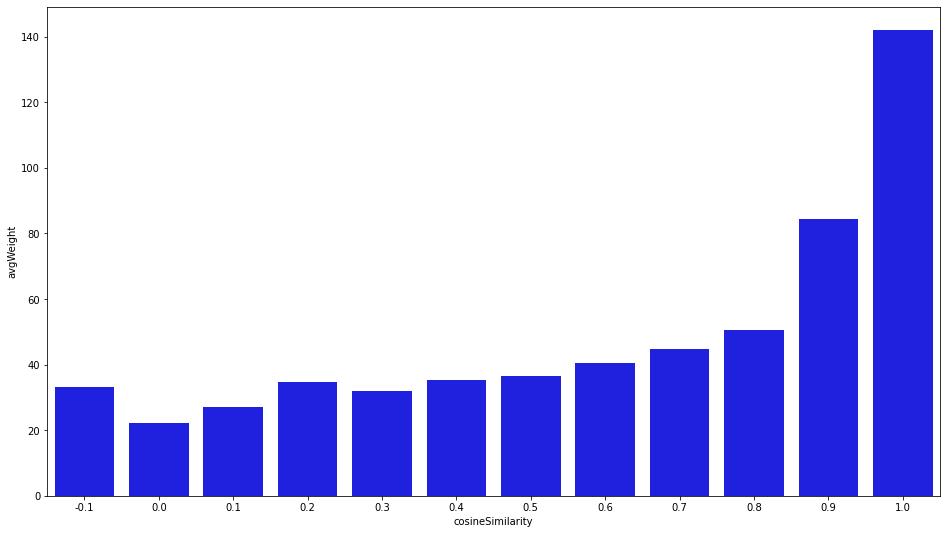

In [11]:
df = run_query("""
MATCH (c1:Stream)-[r:SHARED_AUDIENCE]->(c2:Stream)
WITH c1, c2, gds.similarity.cosine(c1.node2vec, c2.node2vec) AS cosineSimilarity,
     r.weight AS weight
RETURN round(cosineSimilarity,1) AS cosineSimilarity, avg(weight) AS avgWeight
ORDER BY cosineSimilarity
"""
)

sns.barplot(data=df, x="cosineSimilarity", y="avgWeight", color="blue")

In [12]:
data = run_query("""
MATCH (s:Stream)
RETURN s.id AS streamId, s.language AS language, s.node2vec AS embedding
"""
)
data["output"] = pd.factorize(data["language"])[0]

In [13]:
data.head()

,streamId,language,embedding,output
0,129004176,en,"[1.2632083892822266, 0.061601292341947556, 0.8...",0
1,26490481,en,"[1.4853485822677612, 0.15566110610961914, 0.11...",0
2,213749122,en,"[1.4480093717575073, -0.01314368937164545, 0.1...",0
3,30104304,en,"[1.6229671239852905, 0.11407186836004257, 0.42...",0
4,160504245,en,"[1.463451623916626, 0.41780173778533936, 0.397...",0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data["embedding"].to_list()
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       384
           1       0.94      0.93      0.93        54
           2       0.96      0.92      0.94        59
           3       0.83      0.87      0.85        39
           4       0.87      0.92      0.90        52
           5       0.88      0.78      0.83        58
           6       1.00      0.95      0.97        20
           7       0.92      0.88      0.90        25
           8       0.94      0.86      0.90        35
           9       0.95      0.95      0.95        19

    accuracy                           0.91       745
   macro avg       0.92      0.90      0.91       745
weighted avg       0.91      0.91      0.91       745



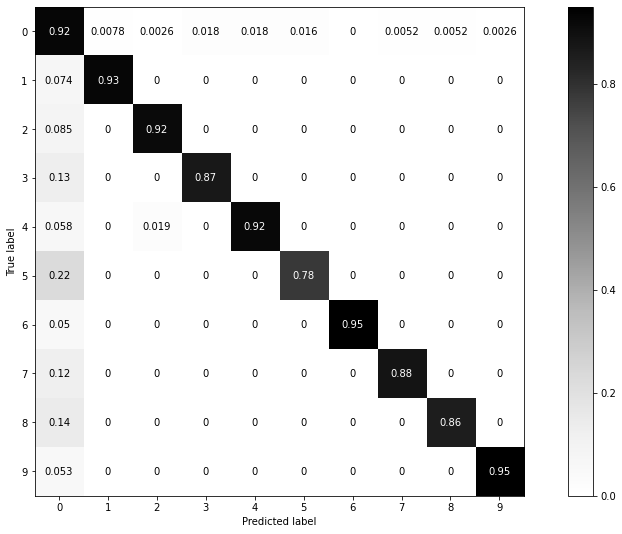

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Greys")

In [17]:
run_query("""
CALL gds.graph.drop('twitch')
"""
)

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,twitch,neo4j,,-1,3721,262854,{'relationshipProjection': {'SHARED_AUDIENCE':...,0.018989,2023-01-04T18:50:06.237196561+01:00,2023-01-04T18:50:06.307828793+01:00,"{'graphProperties': {}, 'relationships': {'SHA..."
